In [2]:
# Main Imports
from ipynb.fs.full.GastricFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd

In [3]:
# Loading Results dataframe
# Prepare this dataframe (total results) only once
# total_results_dataframe = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])

# Only load if needed to load total results from previous runs to continue on
total_results_dataframe_SVM = pd.read_csv("total_GastricCancer_results_SVM.csv")
total_results_dataframe_KNN = pd.read_csv("total_GastricCancer_results_KNN.csv")


In [4]:
# Reading Data
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_only_scaled_data , sample_ID_pixels = ReadGastricData()

In [5]:
## Selecting Patient as test
testPatient_ID = 2
#-------------------------------------------------------

In [6]:
# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_only_scaled_data = sample_only_scaled_data,
        sample_ID_pixels = sample_ID_pixels )

In [7]:
# Run tSNE Model
tsne_results = tSNE(train_scaled_data)
np.save("patient_TSNE/GastricCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 54145 samples in 0.007s...
[t-SNE] Computed neighbors for 54145 samples in 67.683s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54145
[t-SNE] Computed conditional probabilities for sample 2000 / 54145
[t-SNE] Computed conditional probabilities for sample 3000 / 54145
[t-SNE] Computed conditional probabilities for sample 4000 / 54145
[t-SNE] Computed conditional probabilities for sample 5000 / 54145
[t-SNE] Computed conditional probabilities for sample 6000 / 54145
[t-SNE] Computed conditional probabilities for sample 7000 / 54145
[t-SNE] Computed conditional probabilities for sample 8000 / 54145
[t-SNE] Computed conditional probabilities for sample 9000 / 54145
[t-SNE] Computed conditional probabilities for sample 10000 / 54145
[t-SNE] Computed conditional probabilities for sample 11000 / 54145
[t-SNE] Computed conditional probabilities for sample 12000 / 54145
[t-SNE] Computed conditional probabilities for s

In [8]:
# Load tSNE model instead of running model if needed
tsne_results = np.load("patient_TSNE/GastricCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

In [9]:
# Applying KMeans from 3 to 8 clusters
kmeans_3 , kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8 = KMeans_results(tsne_results)

In [10]:
# Reading Clinical data to be applied in survival analysis
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx")

Clinical_data["Surv_time"] = Clinical_data["Surv_time"] / 30
Clinical_data_full["Surv_time"] = Clinical_data_full["Surv_time"] / 30

In [11]:
# Create dict to save kmeans results and select them later
kmeans_dict = { '3_Clusters' : kmeans_3.labels_ , '4_Clusters': kmeans_4.labels_ , '5_Clusters': kmeans_5.labels_ , '6_Clusters': kmeans_6.labels_ , '7_Clusters': kmeans_7.labels_ , '8_Clusters': kmeans_8.labels_ }
colors = ["red" , "green" , "yellow" , "blue", "violet" , "Indigo" , "Orange" , "grey" , "white" , "pink"]

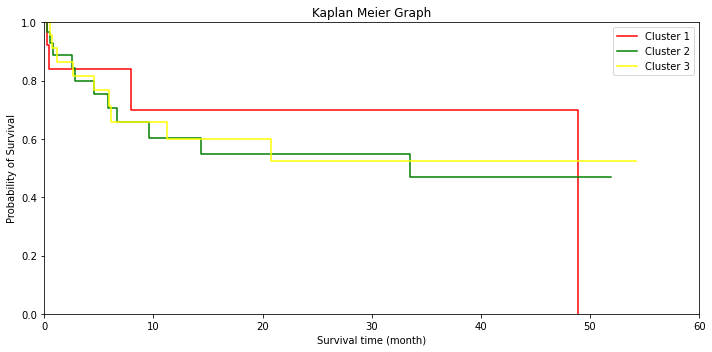

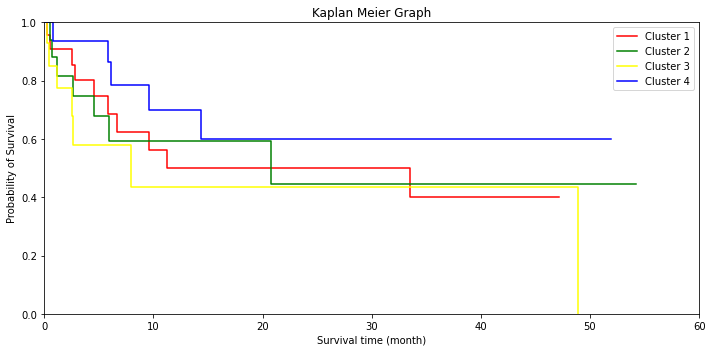

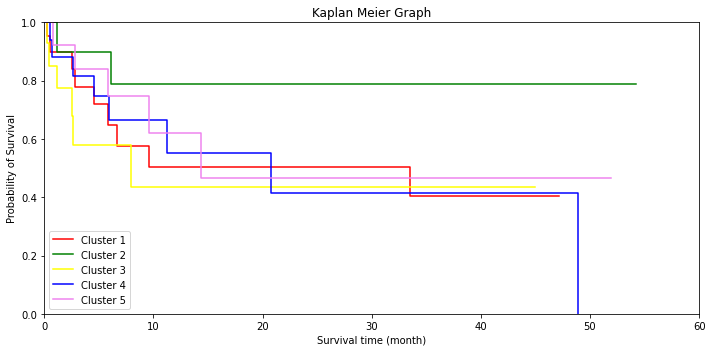

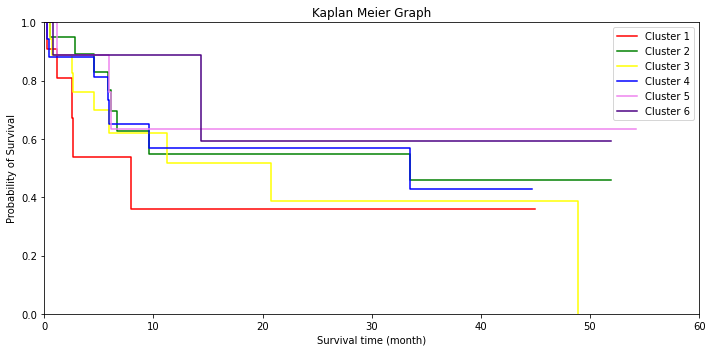

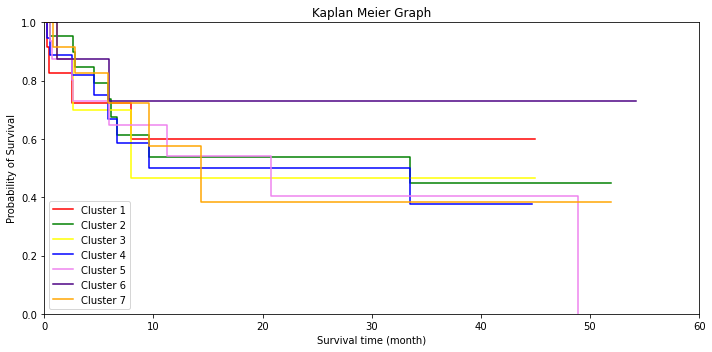

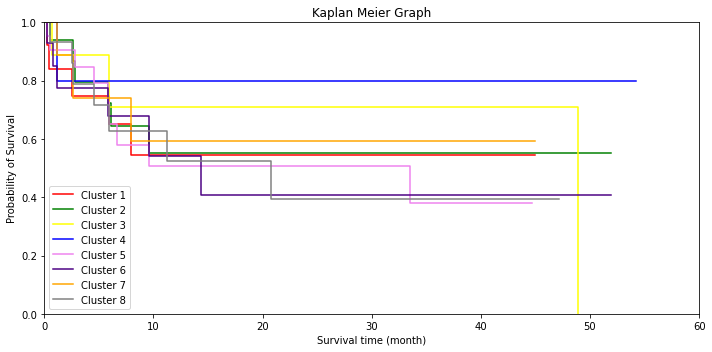

In [12]:
# Perform Kaplan Meier, Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
for i in range(3,9):
    labels = kmeans_dict[str(i)+'_Clusters']
    Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors , sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)

In [84]:
## Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# 3 or 4 or 5 or 6 or 7 or 8 
selected_clusters_value = 3
# ----------------------------------------------------------------------------------

In [85]:
# Using Selected KMeans, apply LogRank test and Kaplan Meier to be used in Cox Hazard
selected_state = kmeans_dict[str(selected_clusters_value) + "_Clusters"]
labels = kmeans_dict[str(selected_clusters_value) + "_Clusters"]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)
plt.close()

Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)

pvalue , SignCluster = SignificantClusters(labels, Results)


print("Significant Clusters are: Cluster " + str(SignCluster[0]+1) + " and Cluster " + str(SignCluster[1]+1))

Significant Clusters are: Cluster 1 and Cluster 2


In [86]:
# Check for signifiance between 2 clusters using cluster_value - 1 if needed
#Results[0][3]

Significant Clusters are:  [1 2]


Text(0.3, 0.05, 'P-value= 0.63')

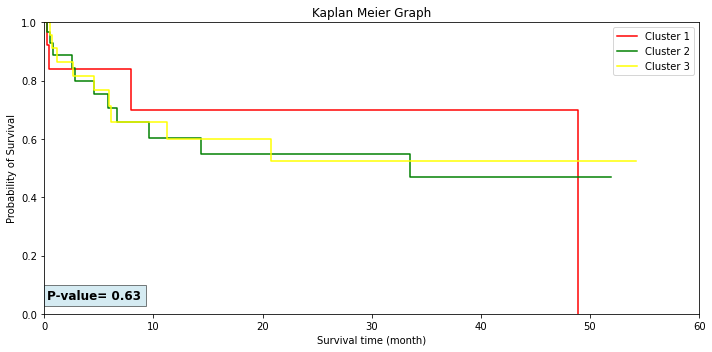

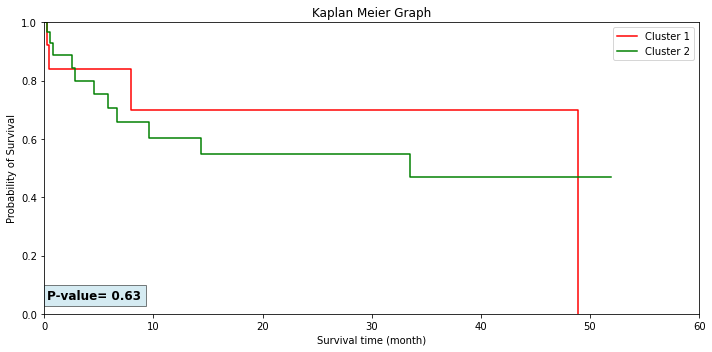

In [87]:
# Plot p-value with Kaplan Meier graphs of selected KMeans
print("Significant Clusters are: " , np.add(SignCluster,1))
SignCluster = [SignCluster[0] , SignCluster[-1]]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))


Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data,SignCluster=SignCluster)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

In [88]:
# Apply CoxHazard Fitter
cph = CoxHazardFitter(labels , Clinical_data = Clinical_data_new)

labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

# Clears output, can be commented if needed
from IPython.display import clear_output
clear_output()
plt.close()

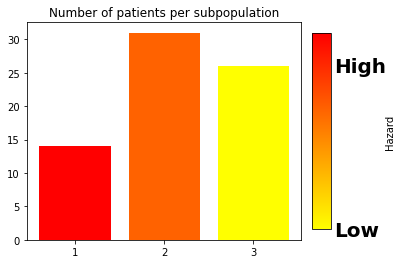

In [89]:
# Plot CoxHazard bar graph to show hazardous value of each cluster
max_tick_value = 11.41 # increase this number till the colorbar shows correctly, take value from highest exp coeff (hazard ratio)
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , max_tick_value = max_tick_value, clusters = Clusters)

In [90]:
# Using coxhazard to determine the significant clusters, check coxhazard before relying on these values
hazardous_cluster_label = np.argmax(cph.hazard_ratios_) # Find the max hazard ratio's index and that will be the hazardous cluster label
survival_cluster_label = np.argmin(cph.hazard_ratios_) # Find the min hazard ratio's index and that will be the highest survival cluster label

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))
print("High Survival cluster label's index is {} and it is cluster {}".format(survival_cluster_label,survival_cluster_label+1))

Hazardous cluster label's index is 0 and it is cluster 1
High Survival cluster label's index is 2 and it is cluster 3


In [91]:
# Manual input cluster labels if needed
# survival_cluster_label = 0
# hazardous_cluster_label = 1

#print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))

In [92]:
# Perform SAM Analysis, Run R file after this cell
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, hazardous_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("GastricCancerAverageSpectrumValues.csv",index=False)

# Run R file in order to generate significant proteins using the csv file

In [93]:
#Need to read significant protein file outputted from R, Create Target labels to be used for KNN and SVM Models

SAM_protein = readSignificantProteins("significant_gastric_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_gastric_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, hazardous_cluster_label , survival_cluster_label)

In [ ]:
# SVM Model , predicting labels
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 0.1 , train_scaled_selected_proteins_data , train_labels , test_scaled_selected_proteins_data)

In [ ]:
# Calculating SVM Probability survival values
Poor_Surv, Moderate_Surv , High_Surv = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Poor_Surv , Moderate_Surv, High_Surv]

In [ ]:
# KNN Model, predicting labels
y_pred_KNN = KNN(5 , train_scaled_selected_proteins_data, train_labels, test_scaled_selected_proteins_data)

In [ ]:
# Calculating KNN Probability values
Poor_Surv, Moderate_Surv , High_Surv  = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Poor_Surv , Moderate_Surv, High_Surv]

In [ ]:
# Selecting KNN as outputted results
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_KNN
Poor_Surv = Selected_model[0]
Moderate_Surv = Selected_model[1]
High_Surv = Selected_model[2]

In [ ]:
# Run after model complete to save the result in the total results dataframe, saving KNN results
total_results_dataframe_KNN = OutputDataframe(total_results_dataframe_KNN, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview KNN results
total_results_dataframe_KNN

In [ ]:
# Saving KNN results in CSV file
# Only run if needed to save and load at a later time
total_results_dataframe_KNN.to_csv("total_GastricCancer_results_KNN.csv" , index = False)

In [ ]:
# Selecting SVM as outputted results
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_SVM
Poor_Surv = Selected_model[0]
Moderate_Surv = Selected_model[1]
High_Surv = Selected_model[2]

In [ ]:
# Run after model complete to save the result in the total results dataframe, saving SVM results
total_results_dataframe_SVM = OutputDataframe(total_results_dataframe_SVM, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview SVM results
total_results_dataframe_SVM

In [ ]:
# Saving SVM results in CSV file
# Only run if needed to save and load at a later time
total_results_dataframe_SVM.to_csv("total_GastricCancer_results_SVM.csv" , index = False)